# Note: Use Notebook viewer (https://nbviewer.org/) to view this code in order to view and appreciate the Maps¶
You just need to put the github link of your notebook in nbviewer(https://nbviewer.org/) and all your maps will be rendered there as they would normally be in a jupyter notebook.

In [ ]:
Arthur: Amobichukwu Amanambu
Objective: 1 explore map with GEE
    2. What is the long term trend of NDVI using Jupyter and GEE
    3. Make random points
    3. DETERMINE the Hramonic model of NDVI trend for the study area

# Harmonic Model
The harmonic analysis of the NDVI time series aims to characterize seasonal changes in the spectral behavior of targets by decomposing the time series into harmonic terms

In [235]:
# the regulars
import pandas as pd
import geopandas as gpd
import json
import os
import requests
import math
import numpy as np
# earth engine
import ee
import geemap
from geemap import eefolium
import folium
from folium import plugins
from geemap import geojson_to_ee, ee_to_geojson
# allow images to display in the notebook
from IPython.display import Image
from ipyleaflet import GeoJSON
from ipygee import*
import proplot as plot

from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

In [16]:
# # Trigger the authentication flow.
# ee.Authenticate()

# # Initialize the library.
# ee.Initialize()

service_account = 'amaobi@micro-rigging-348821.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, r"C:\Users\a.amanambu\Downloads\micro-rigging-348821-30f578b1eb00.json")
ee.Initialize(credentials)

Follow the steps given on this page: https://developers.google.com/earth-engine/guides/service_account

Most importantly "Register the service account to use Earth Engine" so what you have to do is register "cloud-service...iam.gserviceaccount.com" (i.e., your service _account) via this link: https://signup.earthengine.google.com/#!/service_accounts by entering the service_account email in your case "cloud-service...iam.gserviceaccount.com" in the Email field

and that's it, you are good to go without having the need to use ee.Authenticate()

In [309]:
Map = eefolium.Map()
Map.setCenter(-81.760254, 27.994402, 7) #SET CENTER FOR fLORIDA
Map

# Add a chunck of code to the initial code that calculates Linear regression. note that if you do this seperately it will not work expct build within a cell block

In [220]:
# iMPORT shape  file which is the boundary

region = gpd.read_file(r"C:\Users\a.amanambu\Desktop\Chapter 3\Apalachicola_boundary\UPPER_apa\Upper_APA.shp")
js = json.loads(region.to_json())
geometry = ee.Geometry(ee.FeatureCollection(js).geometry())
Map = eefolium.Map()
Map.addLayer(geometry)
Map

dataset5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_32DAY_EVI").filterDate('1999-01-01', '2012-12-31').filterBounds(geometry).select('EVI');



dataset7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_32DAY_EVI").filterDate('2013-01-01', '2017-12-31').filterBounds(geometry).select('EVI');

# merge collections
dataset_merged = dataset5.merge(dataset7)

#clip image with lambda function and sort the resulant image

collection = dataset_merged.map(lambda image: image.clip(geometry))

# create a color code for plotting the NDVI
collectionVis = {
  'min': 0.0,
  'max': 1.0,
  'palette': [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301'
  ],
};

#centralise the map to study area
Map.setCenter(-85.11666666666663, 30.29166666666669, 9.4)

#add the NDVI collection to the color code
Map.addLayer(collection, collectionVis, 'EVI');
Map

In [222]:
#generate random points
Random_points = ee.FeatureCollection.randomPoints(geometry, 100)

In [223]:
# define start and end dates
months = ee.List.sequence(1,12)
years = ee.List.sequence(1999, 2012)

In [224]:
#calc mean And media of the NDVI data collection
Mean_Collection = collection.mean()
Median_Collection = collection.median()

# Use the folium to visualize the generated random points generated for Meana & Median with the study time frame

In [225]:
#Define viuslaisation parameters

visual_parameters = {'min': 0, 'max': 1, 'palette': [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301'
  ]}
basemaps = {
'Google Maps': folium.TileLayer(
tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
attr = 'Google',
name = 'Google Maps',
overlay = True,
control = True
),
'Google Satellite': folium.TileLayer(
tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
attr = 'Google',
name = 'Google Satellite',
overlay = True,
control = True
)}

# write a function to add the random points layers to Map

def Point_layer(self, ee_object, visual_parameters, name):
    try:
        if isinstance(ee_object, ee.image.Image):
            map_id_dict = ee.Image(ee_object).getMapId(visual_parameters)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
            
            # call the image collection
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name, 
            overlay = True,
            control = True
            ).add_to(self)
            
            #call the geometry
        elif isinstance(ee_object, ee.geometry.Geometry):
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
            
            #call all featurecollection
        elif isinstance(ee_object,ee.featurecollection.FeatureCollection):
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
            
            #print Map
    except:
            print("Could not display {}".format(name))
        

        
folium.Map.Point_layer = Point_layer
my_map = folium.Map(location = [30.29166666666669, -85.11666666666663],
                    zoom_start= 8.5)        
basemaps['Google Maps'].add_to(my_map)
my_map.Point_layer(Median_Collection, visual_parameters, 'NDVI')
my_map.Point_layer(Random_points.geometry(), {}, 'RandomPoints')
my_map.add_child(folium.LayerControl())
display(my_map)        


# Make a plot by monthly

In [291]:
NDVItimeseries = chart.Image.series(**{'imageCollection': collection,
'region': geometry,
'reducer': ee.Reducer.mean(),
'scale': 250,
'xProperty': 'system:time_start'})

NDVItimeseries.renderWidget(width='70%')

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

# The ipygee package can allow manipulation of this time series as a dataframe. So using Pandas is crucial in this regard

In [231]:
type(NDVItimeseries.dataframe)

pandas.core.frame.DataFrame

In [238]:
NDVItimeseries.dataframe.index

DatetimeIndex(['1999-01-01', '1999-02-02', '1999-03-06', '1999-04-07',
               '1999-05-09', '1999-06-10', '1999-07-12', '1999-08-13',
               '1999-09-14', '1999-10-16',
               ...
               '2017-03-06', '2017-04-07', '2017-05-09', '2017-06-10',
               '2017-07-12', '2017-08-13', '2017-09-14', '2017-10-16',
               '2017-11-17', '2017-12-19'],
              dtype='datetime64[ns]', length=208, freq=None)

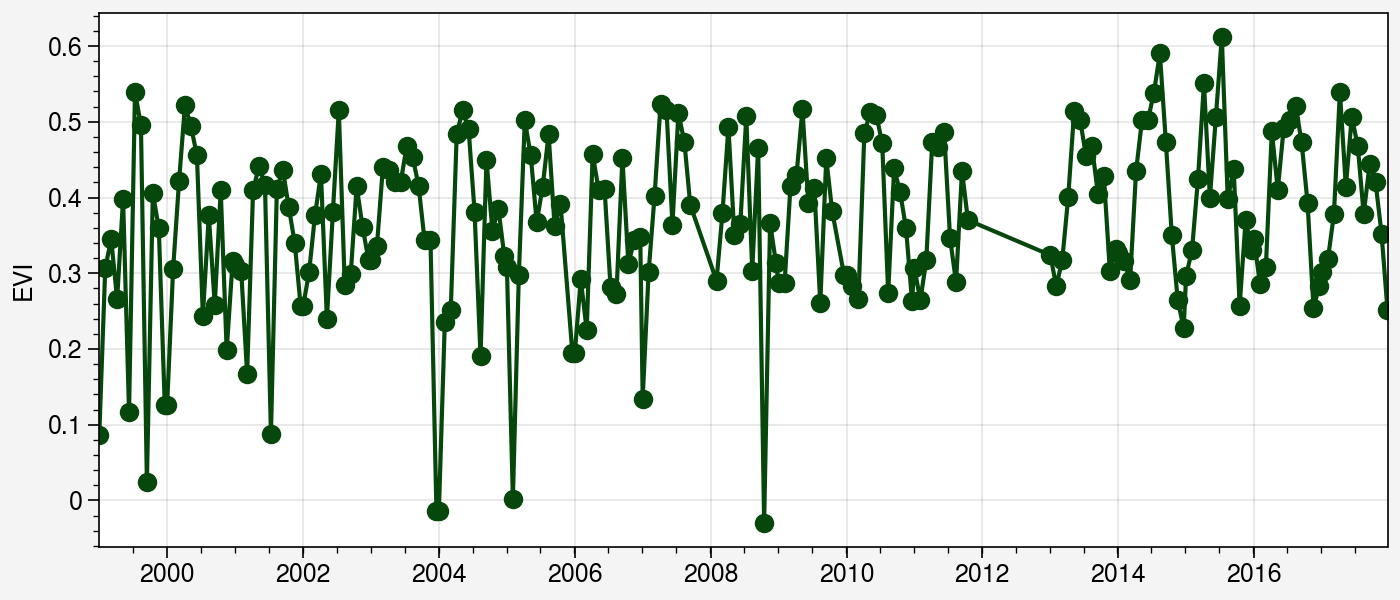

In [292]:
fig, ax = plot.subplots(figsize=(7, 3), tight=True)
ax.plot(NDVItimeseries.dataframe.index, NDVItimeseries.dataframe['EVI'],
        color='forest green', marker='o')
plot.show()

# Harmonic Model

In [300]:
#define bands and number of harmonics
predictor = 'EVI'
harmonics = 10
#make a list of harmonic frequencies
frequencies = list(range(1, harmonics + 1))

In [301]:
#define function for the harmonics

def getNames(start, initial_frequency):
    firstname = []
    for index in initial_frequency:
        firstname.append(ee.String(start + str(index)))
    return firstname

cosine_n = getNames('cos_', frequencies)
sin_n = getNames('sin_', frequencies)
predictants = ee.List(['constant','t']).cat(cosine_n).cat(sin_n)

# Create a functions to add the harmonic and temporal components to the image collection from Landsat

In [302]:
#Add a constant
def constant(image):
    return image.addBands(ee.Image(1));

#Add Time
def time(image):
    image_date = ee.Date(image.get('system:time_start'))
    length_year = image_date.difference(ee.Date('1970-01-01'), 'year')
    Radians_in_time = ee.Image(length_year.multiply(2 * math.pi))
    return image.addBands(Radians_in_time.rename('t').float())

# Add Harmonics
def harmonics (image):
    H_frequencies = ee.Image.constant(frequencies)
    time = ee.Image(image).select('t')
    cosine = time.multiply(H_frequencies).cos().rename(cosine_n)
    sine = time.multiply(H_frequencies).sin().rename(sin_n)
    return image.addBands(cosine).addBands(sine)

In [303]:
#determine the harmonics
EVI_harmonic = collection.map(constant).map(time).map(harmonics)

#determine the harmonic Trend

EVI_harmonic_trend = EVI_harmonic.select(predictants.add(predictor)).reduce(ee.Reducer.linearRegression(predictants.length(), 1))

#determine the coeffient

EVI_harmonic_trend_Coeff = EVI_harmonic_trend.select('coefficients').arrayProject([0]).arrayFlatten([predictants])

#fit the harmonics

fit = EVI_harmonic.map(lambda image : image.addBands(image.select(predictants).multiply(EVI_harmonic_trend_Coeff).reduce('sum').rename('fitted')))

In [304]:
# create a graph of the harmonic model for the the study area:

Harmonic_amplitudes = chart.Image.series(**{'imageCollection': fit,
'region': geometry,
'reducer': ee.Reducer.mean(),
'scale': 250,
'xProperty': 'system:time_start'})

NDVItimeseries.renderWidget(width='70%')

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

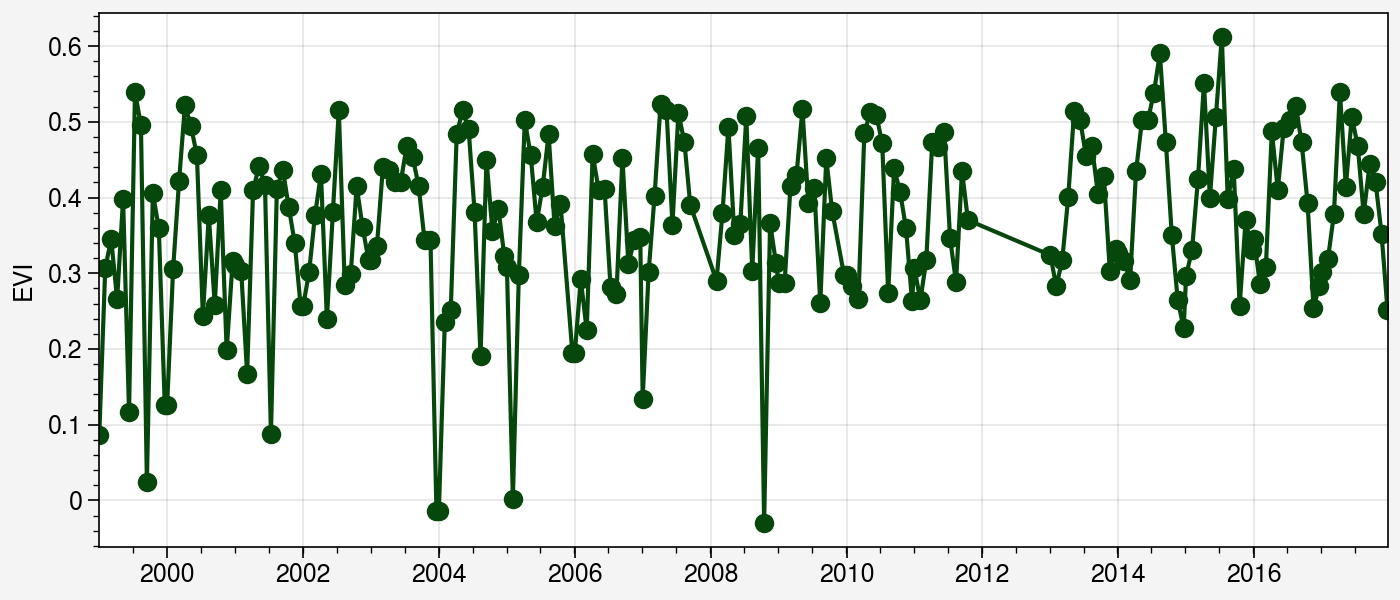

In [305]:
fig, ax = plot.subplots(figsize=(7, 3), tight=True)
ax.plot(Harmonic_amplitudes.dataframe.index, Harmonic_amplitudes.dataframe['EVI'],
        color='forest green', marker='o')
plot.show()